在这个文件中，我们将尝试去生成更加多样化的分子（通过进一步减少每一步所生成的长度）

In [1]:
import torch
import pandas as pd
from collections import Counter
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, url, smiles_col, sequence_length=4):
        self.url = url
        self.smiles_col = smiles_col
        self.sequence_length = sequence_length
        self.smiles = []
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]

    def load_words(self):
        train_df = pd.read_csv(self.url,header=None, names=["SMILES_COL"])
        #train_df=train_df[0:20000]
        self.smiles = list(train_df[self.smiles_col])
        text = train_df[self.smiles_col].str.cat(sep=' ')
        text = "".join(text.split(' '))
        return [text[i] for i in range(len(text))]

    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)

    def __len__(self):
        return len(self.words_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.sequence_length]).to(device),
            torch.tensor(self.words_indexes[index+1:index+self.sequence_length+1]).to(device),
        )

In [2]:
class LSTM_Generator(torch.nn.Module):
    def __init__(self, dataset):
        super(LSTM_Generator, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_words)
        self.embedding = torch.nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = torch.nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = torch.nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)

        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size).to(device),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size).to(device))

In [3]:
def train(dataset, model):
    losses = []
    model.train()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(MAX_EPOCHS):
        state_h, state_c = model.init_state(SEQUENCE_LENGTH)
        total_loss = 0

        for batch, (x, y) in enumerate(dataloader):

            optimizer.zero_grad()

            with torch.enable_grad():
                if not model.training:
                    model.train()

                y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))
                loss = criterion(y_pred.transpose(1, 2), y.to(device))
                total_loss += loss.item()

                state_h = state_h.detach()
                state_c = state_c.detach()

                loss.backward()
                optimizer.step()

        model.eval()
        print("Epoch: {}, Loss: {:.3f}, Generated SMILES: {}".format(
            epoch+1, 
            total_loss,
            get_best_smiles(dataset, model)
            )
        )
        losses.append(total_loss)
    return losses

In [4]:
def train(dataset, model):
    losses = []
    model.train()

    dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    for epoch in range(MAX_EPOCHS):
        state_h, state_c = model.init_state(SEQUENCE_LENGTH)
        total_loss = 0

        for batch, (x, y) in enumerate(dataloader):

            optimizer.zero_grad()

            with torch.enable_grad():
                if not model.training:
                    model.train()

                y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))
                loss = criterion(y_pred.transpose(1, 2), y.to(device))
                total_loss += loss.item()

                state_h = state_h.detach()
                state_c = state_c.detach()

                loss.backward()
                optimizer.step()

        model.eval()
        print("Epoch: {}, Loss: {:.3f}, Generated SMILES: {}".format(
            epoch+1, 
            total_loss,
            get_best_smiles(dataset, model)
            )
        )
        losses.append(total_loss)
    return losses

In [5]:
import random 

def get_best_smiles(dataset, model, next_words=100, max_trial=10, start_length=3):
    best_smile = ""
    for trial in range(max_trial):
        starting_text = random.choice(dataset.smiles)[:start_length]
        smile = predict(dataset, model, text=starting_text, next_words=next_words)
        if len(best_smile) < len(smile):
            best_smile = smile
    return best_smile

In [6]:
def predict(dataset, model, text, next_words=2):
    words = [text[i] for i in range(len(text))]
    model.eval()

    state_h, state_c = model.init_state(len(words))

    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]]).to(device)
        y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))

        last_word_logits = y_pred[0][-1]
        #p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().numpy()
        p = torch.nn.functional.softmax(last_word_logits.cpu(), dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])

    return trim_smiles("".join(words))


In [7]:
from rdkit import Chem

def trim_smiles(smile):
    mol = Chem.MolFromSmiles(smile)
    while not mol:
        if len(smile) == 0: break
        smile = smile[:-1]
        mol = Chem.MolFromSmiles(smile)
    return smile


In [8]:
BATCH_SIZE=256
LEARNING_RATE=1e-3
MAX_EPOCHS=60
SEQUENCE_LENGTH=4

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
import warnings
from rdkit import RDLogger
warnings.filterwarnings("ignore")
RDLogger.DisableLog('rdApp.*')

In [11]:
URL='uspto_reaction_smile_aug.txt'
SMILES_COL = 'SMILES_COL'
dataset = Dataset(url=URL, smiles_col=SMILES_COL)

In [12]:
model = LSTM_Generator(dataset)
model.load_state_dict(torch.load('uspto_model_v1_epoch60.pth'))
model=model.to(device)

In [13]:
import pandas as pd
# reaction_dataset_remove_mapping=pd.read_csv('reaction_dataset_remove_mapping.csv')

In [14]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
# rxn = AllChem.ReactionFromSmarts(class3['rxn_smiles'][5],useSmiles=True)
# Chem.Draw.ReactionToImage(rxn)

In [15]:
def remove_quote(reactants_list):
    reactants_list_remove_quote=[]
    molecule_list = reactants_list.strip("[]").split(", ")
    for i in molecule_list:
        j=i.strip("'")
        reactants_list_remove_quote.append(j)
    return reactants_list_remove_quote    

In [73]:
def smile_aug(text):
    text_mol = Chem.MolFromSmiles(text)
    text_smis = []
    for _ in range(100):
        text_smi = Chem.MolToSmiles(text_mol, doRandom=True)
        if text_smi[-1]!='F' and text_smi[-1]!='I' and text_smi[-2:] != '=O' and text_smi[-2:]!='Br' and text_smi[-2:]!='Cl' and text_smi[-1:]!='B' and text_smi[-1:]!='S':
            text_smis.append(text_smi)
        if len(text_smis)==1:
            break   
    text_smis=list(set(text_smis))
    return text_smis

def phB_smile_aug(text):
    text_mol = Chem.MolFromSmiles(text)
    text_smis = []
    for _ in range(100):
        text_smi = Chem.MolToSmiles(text_mol, doRandom=True)
        if text_smi[-1]!='O' and text_smi[-1]!='F' and text_smi[-1]!='I' and text_smi[-2:] != '=O' and text_smi[-2:]!='Br' and text_smi[-2:]!='Cl' and text_smi[-1:]!='B' and text_smi[-1:]!='S':
            text_smis.append(text_smi)
        if len(text_smis)==1:
            break   
    text_smis=list(set(text_smis))
    return text_smis

In [74]:
def single_step_generation(text):
    mol_list=[]
    smile_list=[]
    for i in range(0,1):
        smile_predict=predict(dataset, model, text)
        smile_list.append(smile_predict)
        mol = Chem.MolFromSmiles(smile_predict)
        mol_list.append(mol)
    return smile_list,mol_list

In [75]:
def Multistep_genaration(step,text):
    step_smile_list=[]
    step_smile_list.append(text)
    for i in range(0,step):
        text_aug=smile_aug(text)
        text_generation,_=single_step_generation(text_aug[0])
        text=text_generation[0]
        step_smile_list.append(text)
    return step_smile_list

def Multistep_genaration_phB(step,text):
    step_smile_list=[]
    step_smile_list.append(text)
    for i in range(0,step):
        text_aug=phB_smile_aug(text)
        text_generation,_=single_step_generation(text_aug[0])
        text=text_generation[0]
        step_smile_list.append(text)
    return step_smile_list   
       

In [55]:
from rdkit import Chem
def remove_duplicate_mols(mols):
    unique_mols = []
    smiles_dict = {}
    for mol in mols:
        # 将分子对象转换为规范SMILES
        smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
        # 将规范SMILES作为字典的键来判断分子是否重复
        if smiles not in smiles_dict:
            # 将分子添加到列表和字典中
            smiles_dict[smiles] = True
            unique_mols.append(mol)
    return unique_mols

In [20]:
step=4
#text_list1=['Brc1ccccc1','Brc1c(C)cccc1C','Brc1ccccc1C(C)(C)C','Brc1c(C(C)(C)C)cccc1C(C)(C)C','n1c(Br)cccc1','n1cc(Br)ccc1','n1ccc(Br)cc1','n1c(Br)=cc=c1','n1c(Br)cncc1','n1c(Br)cccn1','Brc1c(c2ccccc2)cccc1c3ccccc3','Brc1c(c2ccccc2)cccc1','Brc1cccc2c1cccc2','Brc1cccc2c1c(C(C)(C)C)ccc2','Brc1cccc2c1ccc(C(C)(C)C)c2','c1(C(C)(C)C)c(Br)ccc2c1cccc2','C1=CC=C2C(Br)=C3C=CC=CC3=CC2=C1','C1=CC(C(C)(C)C)=C2C(Br)=C3C(C(C)(C)C)=CC=CC3=CC2=C1','C1=CC=C2C(=C1)C(Br)=CC3=CC=CC=C32']
text_list1=['Brc1ccccc1','n1c(Br)cccc1','n1cc(Br)ccc1','n1ccc(Br)cc1','n1c(Br)=cc=c1','n1c(Br)cncc1','n1c(Br)cccn1']

In [21]:
text_list2=[s.replace('Br', 'Cl') for s in text_list1]
text_list3=[s.replace('Br', 'F') for s in text_list1]
text_list4=[s.replace('Br', 'I') for s in text_list1]
text_list=[]
text_list.extend(text_list1)
text_list.extend(text_list2)
text_list.extend(text_list3)
text_list.extend(text_list4)

In [22]:
final_smile_list=[]
for _ in range(10):
     for template in text_list:
        gen_list=Multistep_genaration(step,text=template)
        final_smile_list.append(gen_list)


In [23]:
import re
final_smile_list_to_1d= [item for sublist in final_smile_list for item in sublist]
# Delete Molecules containing free radicals
final_smile_list_to_1d = [s for s in final_smile_list_to_1d if not re.search(r'\[.*?\]', s)]

# for smiles in final_smile_list_to_1d:
#     num_bromine = len(re.findall(r"Br", smiles))
#     if num_bromine <= 1:
#         filtered_smiles_list.append(smiles)

In [24]:
final_mol_list=[]
for i in final_smile_list_to_1d:
    mol = Chem.MolFromSmiles(i)
    # num_bromine = len(mol.GetSubstructMatches(Chem.MolFromSmarts("[Br]")))
    # #Delete Molecules containing more than 2 Br
    # if num_bromine <= 1:
    final_mol_list.append(mol)

In [25]:
final_mol_list_unqiue=remove_duplicate_mols(final_mol_list)

In [26]:
len(final_mol_list_unqiue)

406

In [27]:
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)

,molecule,smiles
0,,Brc1ccccc1
1,,COc1ccccc1Br

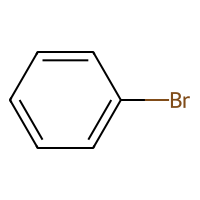
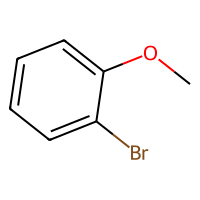

In [30]:
mol_dict = []
for i in final_mol_list_unqiue:
    mol_dict.append({'molecule' : i,  'smiles': Chem.MolToSmiles(i)})
results = pd.DataFrame(mol_dict)
results.head(2)

In [31]:
results.to_pickle('generated_phBr.pkl')

In [76]:
#phB_text_list=['OB(O)c1ccccc1','OB(O)c1c(C)cccc1C','OB(O)c1ccccc1C(C)(C)C','OB(O)c1c(C(C)(C)C)cccc1C(C)(C)C','n1c(B(O)(O))cccc1','n1cc(B(O)(O))ccc1','n1ccc(B(O)(O))cc1','n1c(B(O)(O))=cc=c1','n1c(B(O)(O))cncc1','n1c(B(O)(O))cccn1','OB(O)c1c(c2ccccc2)cccc1c3ccccc3','OB(O)c1c(c2ccccc2)cccc1','OB(O)c1cccc2c1cccc2','OB(O)c1cccc2c1c(C(C)(C)C)ccc2','OB(O)c1cccc2c1ccc(C(C)(C)C)c2','c1(C(C)(C)C)c(B(O)(O))ccc2c1cccc2','C1=CC=C2C(B(O)(O))=C3C=CC=CC3=CC2=C1','C1=CC(C(C)(C)C)=C2C(B(O)(O))=C3C(C(C)(C)C)=CC=CC3=CC2=C1','C1=CC=C2C(=C1)C(B(O)(O))=CC3=CC=CC=C32']
phB_text_list=['OB(O)c1ccccc1','OB(O)c1c(C)cccc1C','n1c(B(O)(O))cccc1','n1cc(B(O)(O))ccc1','n1ccc(B(O)(O))cc1','n1c(B(O)(O))=cc=c1','n1c(B(O)(O))cncc1','n1c(B(O)(O))cccn1','OB(O)c1c(c2ccccc2)cccc1c3ccccc3','OB(O)c1c(c2ccccc2)cccc1','OB(O)c1cccc2c1cccc2','OB(O)c1cccc2c1c(C(C)(C)C)ccc2','c1(C(C)(C)C)c(B(O)(O))ccc2c1cccc2']
phB_final_smile_list=[]
for _ in range(10):
    for template in phB_text_list:
        gen_list=Multistep_genaration_phB(step,text=template)
        phB_final_smile_list.append(gen_list)

phB_final_smile_list_to_1d= [item for sublist in phB_final_smile_list for item in sublist]
# Delete Molecules containing free radicals
phB_final_smile_list_to_1d = [s for s in phB_final_smile_list_to_1d if not re.search(r'\[.*?\]', s)]
phB_final_mol_list=[]
for i in phB_final_smile_list_to_1d:
    mol = Chem.MolFromSmiles(i)
    phB_final_mol_list.append(mol)

phB_final_mol_list_unqiue=remove_duplicate_mols(phB_final_mol_list)


In [77]:
len(phB_final_mol_list_unqiue)

225

,molecule,smiles
0,,OB(O)c1ccccc1
1,,NCc1ccc(B(O)O)cc1
2,,NCc1ccc(B(O)O)cc1CO
3,,CNCc1ccc(B(O)O)cc1CO
4,,Cc1cccc(C)c1B(O)O
...,...,...
220,,O=COc1cccc2c(B(O)O)cccc12
221,,CC(C)(Cl)c1cccc2cccc(B(O)O)c12
222,,CC(C=O)(CO)c1c(B(O)O)ccc2ccccc12
223,,CCc1cccc2c(C(C)(C=O)CO)c(B(O)O)ccc12

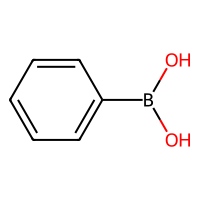
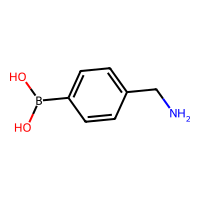
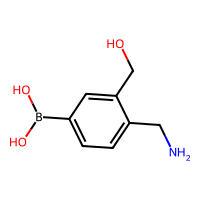
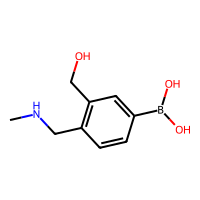
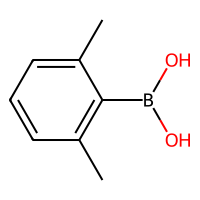
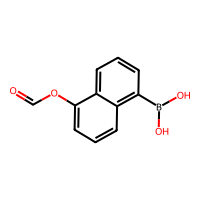
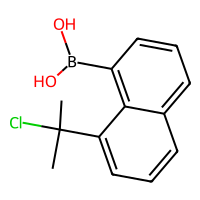
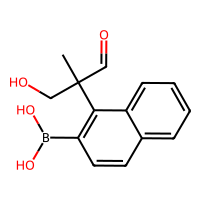
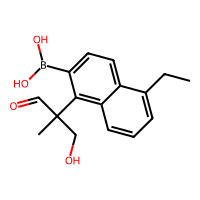
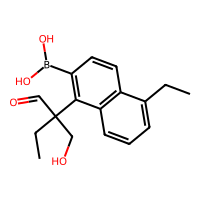

In [78]:
phB_mol_dict = []
for i in phB_final_mol_list_unqiue:
    phB_mol_dict.append({'molecule' : i,  'smiles': Chem.MolToSmiles(i)})
phB_results = pd.DataFrame(phB_mol_dict)
phB_results

In [79]:
phB_results.to_pickle('generated_phB.pkl')

In [58]:
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
def cal_sim(A,A_n):
    mol_A=Chem.MolFromSmiles(A)
    mol_An=Chem.MolFromSmiles(A_n)
    mol_A_maccs_fps=MACCSkeys.GenMACCSKeys(mol_A)
    mol_An_maccs_fps=MACCSkeys.GenMACCSKeys(mol_An)
    sim_A_An=DataStructs.FingerprintSimilarity(mol_A_maccs_fps,mol_An_maccs_fps,metric=DataStructs.DiceSimilarity)
    return sim_A_An

In [59]:
results['sim'] = results['smiles'].apply(lambda x: cal_sim(x, 'Brc1ccccc1'))

In [60]:
results= results.sort_values(by='sim', ascending=False)

,molecule,smiles,sim
0,,Brc1ccccc1,1.000000
299,,Cc1cccc(Br)c1,0.933333
116,,CCc1ccc(Br)cc1,0.823529
2,,Clc1ccccc1Br,0.823529
1,,Cc1ccccc1Br,0.823529
237,,Brc1ccccc1I,0.823529
32,,Brc1cccc2ccccc12,0.777778
43,,Brc1c2ccccc2cc2ccccc12,0.777778
47,,Brc1cc2ccccc2c2ccccc12,0.777778
4,,Cc1cccc(Cl)c1Br,0.777778

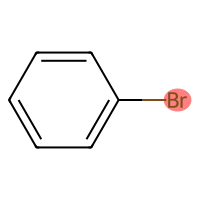
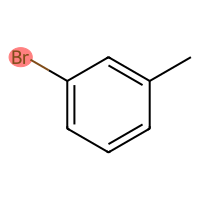
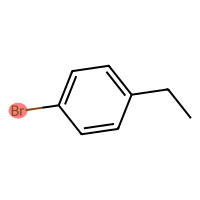
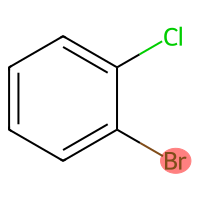
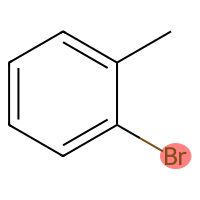
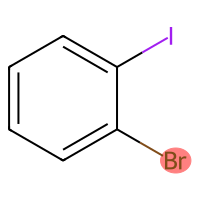
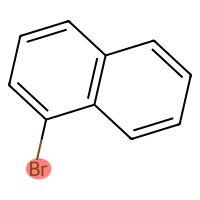
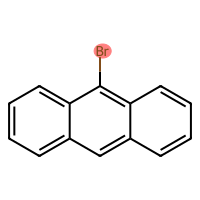
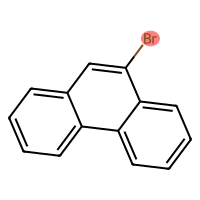
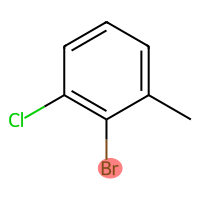

In [61]:
results.head(10)

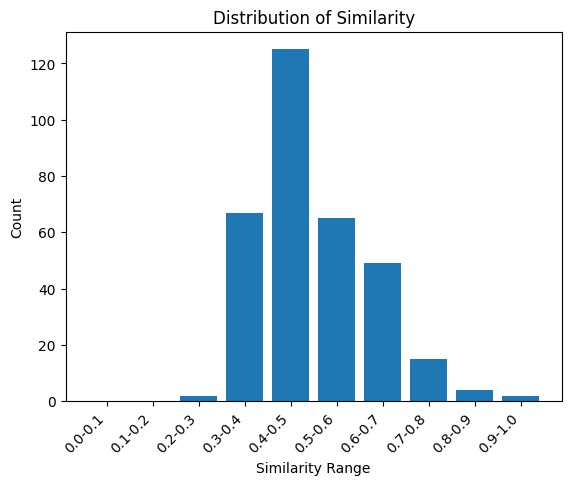

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sim_list = results['sim']
bins = np.linspace(0, 1, 11)
labels = [f'{i:.1f}-{j:.1f}' for i, j in zip(bins[:-1], bins[1:])]
sim_range = pd.cut(sim_list, bins=bins, labels=labels)
counts = sim_range.value_counts().sort_index()

plt.bar(counts.index, counts.values)
plt.xlabel('Similarity Range')
plt.ylabel('Count')
plt.title('Distribution of Similarity')
plt.xticks(rotation=45, ha='right')
plt.show()

Calculate Charge of Reaction Center

In [63]:
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles
def cal_charge_reaction_center(smile):
    mol = MolFromSmiles(smile)
    # get GasteigerCharge
    AllChem.ComputeGasteigerCharges(mol)
    br_atom = mol.GetSubstructMatch(Chem.MolFromSmarts('[Br]'))[0]
    c_atom = [a.GetIdx() for a in mol.GetAtomWithIdx(br_atom).GetNeighbors() if a.GetSymbol() == 'C'][0]
    c_charge = mol.GetAtomWithIdx(c_atom).GetProp('_GasteigerCharge')
    c_charge=float(c_charge)
    return c_charge
    

In [64]:
results['charge'] = results['smiles'].apply(lambda x: cal_charge_reaction_center(x))

,molecule,smiles,sim,charge
0,,Brc1ccccc1,1.000000,0.017475
299,,Cc1cccc(Br)c1,0.933333,0.017739
116,,CCc1ccc(Br)cc1,0.823529,0.017495
2,,Clc1ccccc1Br,0.823529,0.036123
1,,Cc1ccccc1Br,0.823529,0.020398
...,...,...,...,...
321,,CCCC(C)(C)c1c(OC)ccc2c(NC)ccc(Br)c12,0.304348,0.025912
230,,COCC(C)(C)c1cccc2ccc(OCO)c(Br)c12,0.304348,0.067786
190,,COCCc1ccnc(CN)c1Br,0.304348,0.043656
310,,COCCc1cnnc(Br)c1OC,0.280000,0.170370

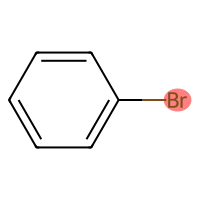
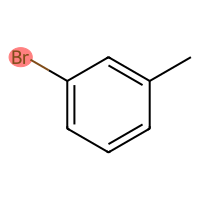
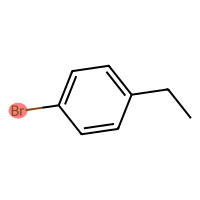
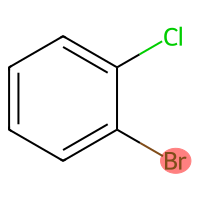
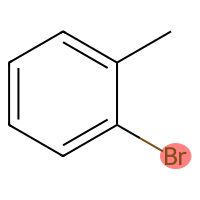
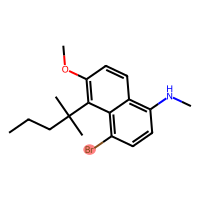
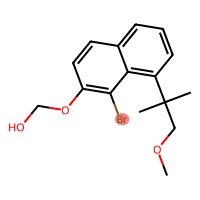
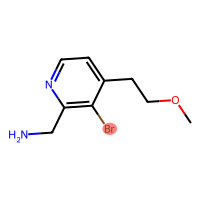
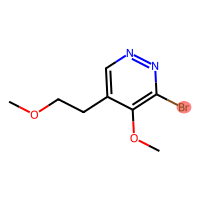
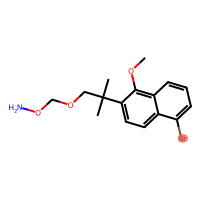

In [65]:
results

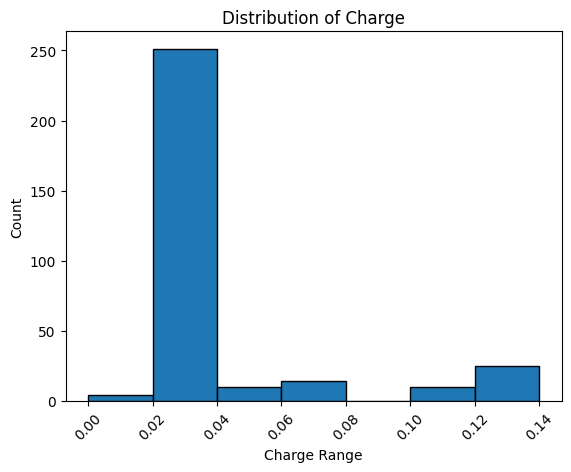

In [66]:
charge_list = results['charge']
bins = np.arange(0, 0.16, 0.02)
hist, _ = np.histogram(charge_list, bins=bins)

# 绘制直方图
fig, ax = plt.subplots()
ax.bar(bins[:-1], hist, width=0.02, align='edge', edgecolor='black', color='#1f77b4')
ax.set_xlabel('Charge Range')
ax.set_ylabel('Count')
ax.set_title('Distribution of Charge')
ax.set_xticks(bins)
ax.tick_params(axis='x', rotation=45)
plt.show()

Calculate Reaction Steric Hindrance

In [67]:
import math

In [68]:
VanderWaals_radius={ 'H': 1.08,'B':1.47,'C': 1.49,'N':1.41,'O':1.40,'F':1.39,'P':1.92,'S':1.82,'Cl':1.63, 'Br': 1.98,'I':2.23}

In [69]:
def get_coordinate(smile):
    mol = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)
    br_idx = mol.GetSubstructMatch(Chem.MolFromSmarts('[Br]'))[0]
    #print(br_idx)
    br_atom = mol.GetAtomWithIdx(br_idx)
    neighbor=br_atom.GetNeighbors()[0]
    if neighbor.GetSymbol() == 'C':
        c_atom = neighbor
    c_idx = c_atom.GetIdx()
    num_atoms = mol.GetNumAtoms()
    atom_dict = {}
    for i in range(num_atoms):
        atom = mol.GetAtomWithIdx(i)
        pos = mol.GetConformer().GetAtomPosition(i)
        r_vdw =VanderWaals_radius[atom.GetSymbol()]
        atom_dict[i] = (atom.GetSymbol(), [pos.x, pos.y, pos.z],r_vdw)
    return atom_dict,br_idx, c_idx 

In [70]:
def Sphere_cal(molecule):
    atom_dict,br_idx, c_idx=get_coordinate(molecule)
    Rs_i_list=[]
    for i in range(len(atom_dict)):
        distance=np.linalg.norm(np.array(atom_dict[c_idx][1]) - np.array(atom_dict[i][1]))
        #print(distance)
        r_vdw=atom_dict[i][2]
        if distance<3 and i!=br_idx and i!=c_idx:
            Rs_i=(r_vdw*r_vdw)/(4*distance*distance)
            Rs_i_list.append(Rs_i)
    #print(Rs_i_list)
    #Rs=-30*(math.log10(1-sum(Rs_i_list)))
    Rs=sum(Rs_i_list)
    return Rs 

In [71]:
results['Sphere'] = results['smiles'].apply(lambda x: Sphere_cal(x))

,molecule,smiles,sim,charge,Sphere
0,,Brc1ccccc1,1.000000,0.017475,0.951303
299,,Cc1cccc(Br)c1,0.933333,0.017739,0.952074
116,,CCc1ccc(Br)cc1,0.823529,0.017495,0.952314
2,,Clc1ccccc1Br,0.823529,0.036123,0.971868
1,,Cc1ccccc1Br,0.823529,0.020398,1.041879
...,...,...,...,...,...
321,,CCCC(C)(C)c1c(OC)ccc2c(NC)ccc(Br)c12,0.304348,0.025912,1.015449
230,,COCC(C)(C)c1cccc2ccc(OCO)c(Br)c12,0.304348,0.067786,1.059282
190,,COCCc1ccnc(CN)c1Br,0.304348,0.043656,1.089413
310,,COCCc1cnnc(Br)c1OC,0.280000,0.170370,0.893225

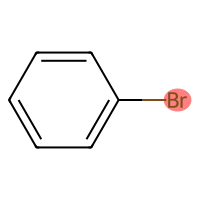
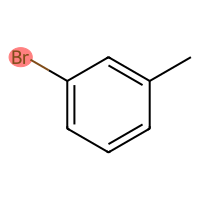
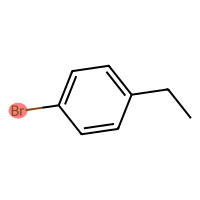
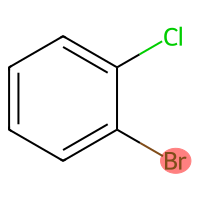
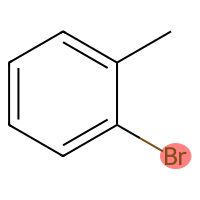
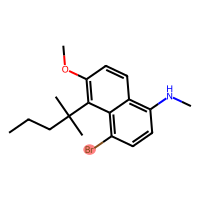
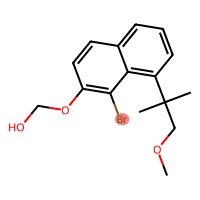
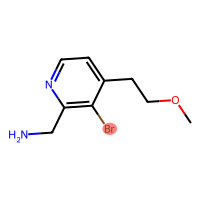
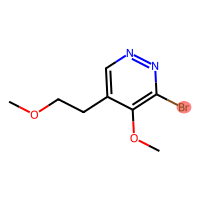
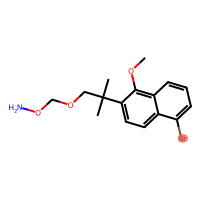

In [72]:
results

In [73]:
results.to_pickle('results_gen_brph.pkl')

In [54]:
results.to_csv('result_genv6.csv', index=False)

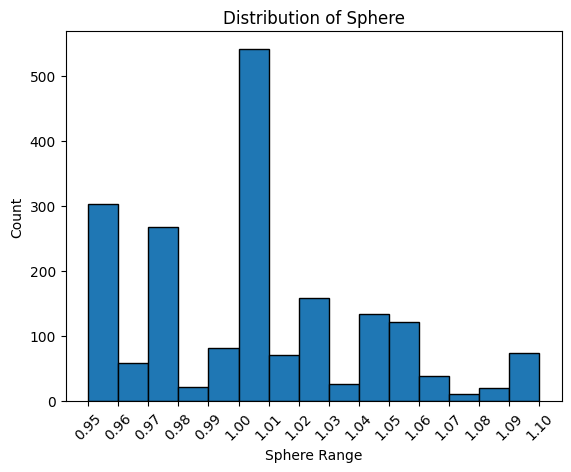

In [55]:
Sphere_list = results['Sphere']
bins = np.arange(0.95, 1.1, 0.01)
hist, _ = np.histogram(Sphere_list, bins=bins)

# 绘制直方图
fig, ax = plt.subplots()
ax.bar(bins[:-1], hist, width=0.01, align='edge', edgecolor='black', color='#1f77b4')
ax.set_xlabel('Sphere Range')
ax.set_ylabel('Count')
ax.set_title('Distribution of Sphere')
ax.set_xticks(bins)
ax.tick_params(axis='x', rotation=45)
plt.show()

In [186]:
Sphere_cal('Cc1cccc(Br)c1')

0.9520744527524324

In [187]:
Sphere_cal('c1cccc(Br)c1')

0.9513026101008192

In [188]:
Sphere_cal('Brc1ccccc1')

0.9513025756500199

In [189]:
Sphere_cal('Brc1c(CC)c(c1ccccc1)ccc1')

0.9062711443802204

In [190]:
Sphere_cal('COC=COCSOc1ccc(Br)c(SCCCSC)c1CCN')

1.027423251321924

In [191]:
Sphere_cal('Cc1cccc(Br)c1')

0.9520742410755674

1) smile_to_sdf

In [44]:
from rdkit.Chem import AllChem
def smiles_to_sdf(smiles):
    mol = AllChem.AddHs(Chem.MolFromSmiles(smiles))
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol)
    return Chem.MolToMolFile(mol,'test1.sdf')
      

In [51]:
smiles_to_sdf('Brc1ccccc1')

In [46]:
smiles_to_sdf('Brc1c(CC)c(c1ccccc1)ccc1')

In [47]:
mols_suppl = Chem.SDMolSupplier('test.sdf')

In [48]:
mols_suppl 

In [94]:
mol = Chem.MolFromSmiles('Brc1ccccc1')
mol = Chem.AddHs(mol)
AllChem.EmbedMolecule(mol)
AllChem.UFFOptimizeMolecule(mol)
conf = mol.GetConformer()
positions = conf.GetPositions()

In [95]:
c_atom=mol.GetAtomWithIdx(0)
neigh=c_atom.GetNeighbors()
for i in neigh:
    print(i.GetSymbol())

C


In [96]:
VanderWaals_radius={ 'H': 1.08,'C': 1.49,'N':1.41,'O':1.40,'F':1.39,'S':1.82,'Cl':1.63, 'Br': 1.98,'I':2.23}

In [ ]:
import math
def Sphere_cal(molecule):
    atom_dict,br_idx, c_idx=get_coordinate(molecule)
    Rs_i_list=[]
    for i in range(len(atom_dict)):
        distance=np.linalg.norm(np.array(atom_dict[c_idx][1]) - np.array(atom_dict[i][1]))
        print(distance)
        r_vdw=atom_dict[i][2]
        if distance<2.42 and i!=br_idx and i!=c_idx:
            Rs_i=(r_vdw*r_vdw)/(4*distance*distance)
            Rs_i_list.append(Rs_i)
    print(Rs_i_list)
    Rs=-30*(math.log10(1-sum(Rs_i_list)))
    return Rs 

In [139]:
# mol = Chem.MolFromSmiles('Brc1c(CC)c(c1ccccc1)ccc1')
# mol = Chem.AddHs(mol)
# AllChem.EmbedMolecule(mol)
# AllChem.UFFOptimizeMolecule(mol)
# num_atoms = mol.GetNumAtoms()
# atom_dict = {}
# for i in range(num_atoms):
#     atom = mol.GetAtomWithIdx(i)
#     pos = mol.GetConformer().GetAtomPosition(i)
#     r_vdw =VanderWaals_radius[atom.GetSymbol()]
#     atom_dict[i] = (atom.GetSymbol(), [pos.x, pos.y, pos.z],r_vdw)
# print(atom_dict)

In [117]:
Sphere_cal(atom_dict)

1.9098361471021297
0.0
1.4000231175854028
2.4241827857507974
2.7992006213069036
2.4241827735670505
1.4000231204316598
2.1578984426304557
3.4047548612072327
3.881535759911613
3.4047548550212126
2.157898442850384
[0.2831666687171719, 0.28316666756581216, 0.06262179562483491, 0.06262179561207037]


15.325594222524483

In [138]:
Sphere_cal('Brc1ccccc1')

0
1.9098362629726102
0.0
1.4000229987834756
2.42418279865224
2.7992007524881934
2.424183049854966
1.400022881794902
2.1578978673584994
3.404755503101929
3.8815359423185907
3.4047555770205635
2.157896745650957
[0.28316671677459293, 0.2831667640984933, 0.06262182901341018, 0.06262189411698506]


15.325605902132418

In [126]:
# import sys
# sys.path.append('.')
from SPMS import SPMS

In [129]:
spms = SPMS.SPMS('test.sdf',desc_n=40,desc_m=40,sphere_radius=8)

In [130]:
spms.GetSphereDescriptors()
desc = spms.sphere_descriptors

In [141]:
#desc

In [138]:
sum(sum(desc))

16794.977723830005

In [145]:
spms1 = SPMS.SPMS('test1.sdf',desc_n=40,desc_m=40,sphere_radius=8)
spms1.GetSphereDescriptors()
desc1 = spms1.sphere_descriptors
sum(sum(desc1))

14885.382746190004

In [52]:
# img=Draw.MolsToGridImage(final_mol_list_unqiue,molsPerRow=4,subImgSize=(300,300),legends=['' for x in final_mol_list_unqiue])
# img

In [68]:
from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles

# 读取分子
mol = MolFromSmiles('Brc1ccccc1Br')

# 计算分子的GasteigerCharge
AllChem.ComputeGasteigerCharges(mol)

# 获取与溴相连的碳原子的GasteigerCharge
br_atom = mol.GetSubstructMatch(Chem.MolFromSmarts('[Br]'))[0]
c_atom = [a.GetIdx() for a in mol.GetAtomWithIdx(br_atom).GetNeighbors() if a.GetSymbol() == 'C'][0]
c_charge = mol.GetAtomWithIdx(c_atom).GetProp('_GasteigerCharge')
print(c_charge)

0.031694731365500772


In [30]:
from rdkit.Chem import Descriptors
descrs = [Descriptors.CalcMolDescriptors(mol) for mol in mol_list]
df = pd.DataFrame(descrs)
df.head()
df.head(3)

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,3.311250,3.311250,1.134259,1.134259,0.542045,157.010,151.970,155.957462,36,0,...,0,0,0,0,0,0,0,0,0,0
1,3.457245,3.457245,0.918079,0.918079,0.770811,200.079,189.999,198.999661,54,0,...,0,0,0,0,0,0,0,0,0,0
2,8.492046,8.492046,0.015213,0.015213,0.749919,216.078,205.998,214.994576,60,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
m = Chem.MolFromSmiles('Brc1ccccc1Br')
AllChem.ComputeGasteigerCharges(m)
m.GetAtomWithIdx(0).GetDoubleProp('_GasteigerCharge')
contribs = [float(m.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) for i in range(m.GetNumAtoms())]
contribs

[-0.049607035473685654,
 0.03169473136550077,
 -0.04683121093148372,
 -0.06106671051334338,
 -0.06106671051334338,
 -0.04683121093148372,
 0.03169473136550077,
 -0.049607035473685654]

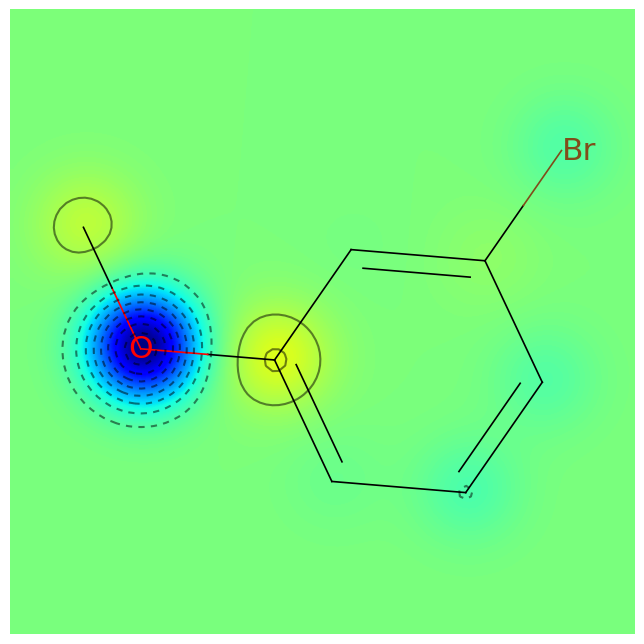

In [136]:
from rdkit.Chem.Draw import SimilarityMaps
mol = Chem.MolFromSmiles('c1ccc(OC)cc1Br')
AllChem.ComputeGasteigerCharges(mol)
contribs = [float(mol.GetAtomWithIdx(i).GetProp('_GasteigerCharge')) for i in range(mol.GetNumAtoms())]
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol, contribs, colorMap='jet', contourLines=10)